# First Try 

Data From

https://github.com/kaa/coins-dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

Create Train and Test Data

explanation: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

?Größe von Train und Test Data nachfragen?

s. Dog_Cats 

https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

In [46]:
datagen=ImageDataGenerator(rescale=1./255,
    validation_split=0.20)

batch_size=64   
data_dir = 'new_extended_dataset/original'
target_size = 200

train_data = datagen.flow_from_directory(data_dir,
    target_size=(target_size,target_size),
    class_mode="categorical", 
    batch_size=batch_size, 
    subset="training")

val_data = datagen.flow_from_directory(data_dir,
    target_size=(target_size,target_size),
    class_mode="categorical", 
    batch_size=batch_size, 
    subset="validation")

Found 7734 images belonging to 8 classes.
Found 1930 images belonging to 8 classes.


In [47]:
train_images, train_labels = train_data.next()
val_images, val_labels = val_data.next()
print(train_images.shape, train_images.dtype)
print(val_images.shape, val_images.dtype)

train_labels_shaped = np.array([])
for i in train_labels:
    i = np.where(i == 1)
    train_labels_shaped = np.append([train_labels_shaped],[i])

val_labels_shaped = np.array([])
for i in val_labels:
    i = np.where(i == 1)
    val_labels_shaped = np.append([val_labels_shaped],[i])

train_labels_shaped = train_labels_shaped.astype("uint8")
val_labels_shaped = val_labels_shaped.astype("uint8")

print(train_labels.shape)
print(val_labels.shape)
print(train_labels_shaped.shape)
print(val_labels_shaped.shape)

print(np.bincount(train_labels_shaped))
print(np.bincount(val_labels_shaped))

(64, 200, 200, 3) float32
(64, 200, 200, 3) float32
(64, 8)
(64, 8)
(64,)
(64,)
[ 5  7  9 13  7  7  3 13]
[10 10  9  4  9  8  5  9]


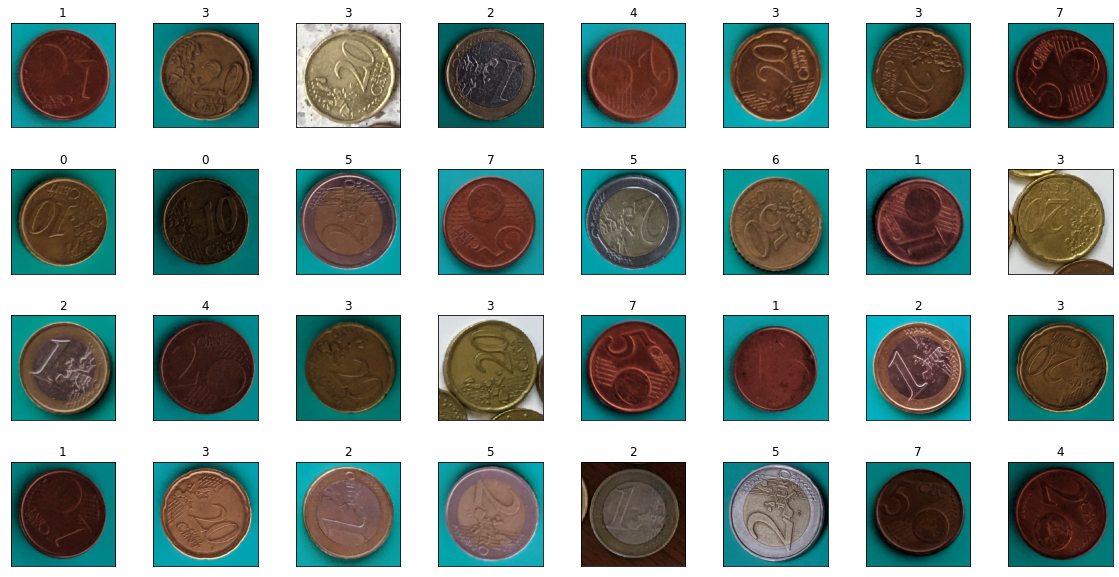

In [48]:
fig1 = plt.figure(figsize=(20,10))
fig1.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(train_images[:32]):
    ax = fig1.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    plt.title(np.argmax(train_labels[i]))

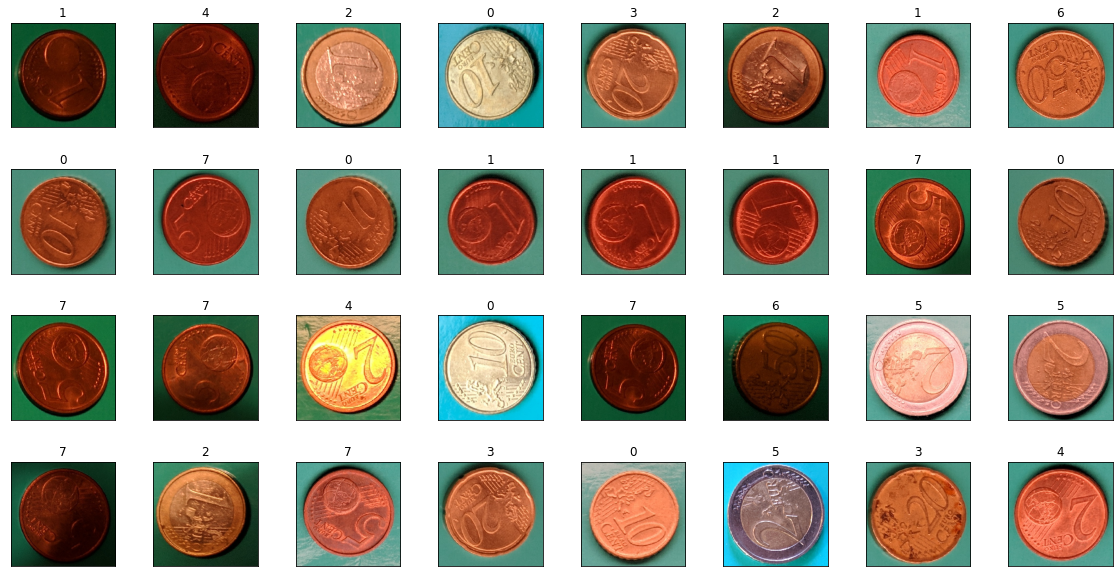

In [49]:
fig2 = plt.figure(figsize=(20,10))
fig2.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(val_images[:32]):
    ax = fig2.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    plt.title(np.argmax(val_labels[i]))

Preprocessing 

In [50]:
train_ds = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_types = (tf.float32, tf.uint8),
    output_shapes = ([None, target_size, target_size, 3], [None, 8]),
)
print(train_ds)


<FlatMapDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))>


In [51]:
val_ds = tf.data.Dataset.from_generator(
    lambda: val_data,
    output_types = (tf.float32, tf.uint8),
    output_shapes = ([None, target_size, target_size, 3], [None, 8]),
)
print(val_ds)

<FlatMapDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))>


Works sometimes (Beim ersten ausführen oder nach einem Restart)

Links for data_augmentation:

https://keras.io/examples/vision/image_classification_from_scratch/#two-options-to-preprocess-the-data

https://www.tensorflow.org/tutorials/images/data_augmentation


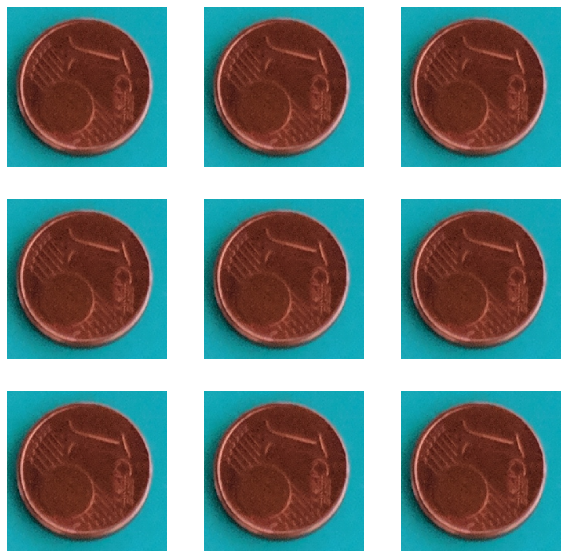

In [52]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  #layers.RandomContrast(factor=0.5),
])
    
#works sometimes (First try & Restart)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1, xticks=[], yticks=[])
        plt.imshow(augmented_images[0])
        plt.axis("off")

Modelbuilding

In [53]:
# provide  (image_height, image_width, image_channels)
inputs = keras.Input(shape=(target_size,target_size, 3))

#Nur mit Datasets möglich (nicht mit DirectoryIterator)
x = data_augmentation(inputs)

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)

x = layers.SpatialDropout2D(0.5)(x)

#Flatten oder GlobalAveragePooling2D s. https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras
#GlobalAveragePooling2D gut gegen overfitting
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)

#x = layers.Dense(32, activation='relu')(x)

# use softmax activation
outputs = layers.Dense(8, activation="softmax")(x)

# define inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

#for filter in [128,64,32]:
#    x = layers.Conv2D(filters=filter, kernel_size=3, activation="relu")(x)
#    x = layers.MaxPooling2D(pool_size=2)(x)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                      

In [54]:
# use rmsprop
model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

Model training

In [55]:
# Training für Dataset
epochs=50

history = model.fit(train_ds,
#Steps_per_epoch nötig ansonsten n/unknown for infinity
steps_per_epoch = train_data.samples // batch_size,
validation_data = val_ds,
validation_steps = val_data.samples // batch_size,
epochs =epochs)

Epoch 1/50
120/120 [==============================] - 122s 1s/step - loss: 1.3068 - accuracy: 0.4587 - val_loss: 1.8209 - val_accuracy: 0.4025
Epoch 2/50
120/120 [==============================] - 116s 970ms/step - loss: 0.8143 - accuracy: 0.6385 - val_loss: 2.0356 - val_accuracy: 0.4250
Epoch 3/50
120/120 [==============================] - 116s 971ms/step - loss: 0.7018 - accuracy: 0.7001 - val_loss: 2.3679 - val_accuracy: 0.4930
Epoch 4/50
120/120 [==============================] - 116s 969ms/step - loss: 0.5895 - accuracy: 0.7524 - val_loss: 1.9564 - val_accuracy: 0.5086
Epoch 5/50
120/120 [==============================] - 117s 974ms/step - loss: 0.4712 - accuracy: 0.8089 - val_loss: 2.3587 - val_accuracy: 0.5011
Epoch 6/50
120/120 [==============================] - 125s 1s/step - loss: 0.4142 - accuracy: 0.8366 - val_loss: 2.4615 - val_accuracy: 0.5552
Epoch 7/50
120/120 [==============================] - 129s 1s/step - loss: 0.3596 - accuracy: 0.8649 - val_loss: 2.1556 - val_accu

In [ ]:
# Training für DirectoryIterator
# Ignorieren
epochs=5

history2 = model.fit(train_data,
validation_data = val_data,
epochs = epochs)

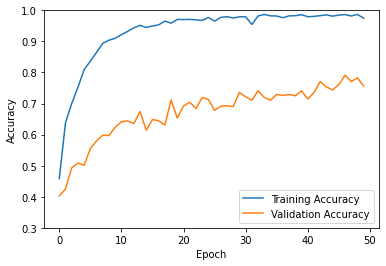

In [56]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

Safe and Load Model

https://www.tensorflow.org/guide/keras/save_and_serialize

In [57]:
model.save('Models/maxConv2D_512_Flatten_50/extended_data_set')

INFO:tensorflow:Assets written to: Models/maxConv2D_512_Flatten_50/extended_data_set\assets


In [59]:
model_loaded = keras.models.load_model('Models/maxConv2D_512_Flatten_50/Big_data_set')


Evaluation
s. cv-extended

In [60]:
val_loss, val_acc = model_loaded.evaluate(val_images,  val_labels, verbose=2)
val_loss, val_acc = model.evaluate(val_images,  val_labels, verbose=2)

2/2 - 0s - loss: 3.9234 - accuracy: 0.6250 - 304ms/epoch - 152ms/step
2/2 - 0s - loss: 2.0927 - accuracy: 0.6406 - 281ms/epoch - 141ms/step


In [61]:
class_names = ['10 Cent', '1 Cent', '1 Euro', '20 Cent', '2 Cent',
               '2 Euro', '50 Cent', '5 Cent']

In [62]:
#Prediction
i=0
predictions = model_loaded.predict(val_images)
print(predictions[i])
print(class_names[np.argmax(predictions[i])])

#True
print(val_labels[i])
print(class_names[val_labels_shaped[i]])

[8.0126082e-04 8.0513644e-01 4.0313268e-09 8.0184138e-05 1.9314525e-01
 1.1771840e-09 1.0912216e-05 8.2592882e-04]
1 Cent
[0. 1. 0. 0. 0. 0. 0. 0.]
1 Cent


In [63]:
error_pred = []
false_pred = []

for i in range(0,63):
    true_label_ = val_labels_shaped[i]
    predicted_label_ = np.argmax(predictions[i])
    if true_label_ != predicted_label_:
        error_pred.append(predicted_label_)
        false_pred.append(true_label_)

#falsche kategoriesierung
print(np.unique(error_pred))
#print(np.bincount(error_pred))
#falsch kategorisiert
print(np.unique(false_pred))
#print(np.bincount(false_pred))

print("-----------------")
print("Münzen werden fälschlicherweise für folgende Kategorien gehalten")

for i in np.unique(error_pred):
    print(class_names[i])
print(np.bincount(error_pred))
print("-----------------")
print("Diese Münzen werden falsch erkannt")

for i in np.unique(false_pred):
    print(class_names[i])
print(np.bincount(false_pred))    


[0 3 4 6]
[0 1 2 4 5 6 7]
-----------------
Münzen werden fälschlicherweise für folgende Kategorien gehalten
10 Cent
20 Cent
2 Cent
50 Cent
[ 3  0  0  2  5  0 14]
-----------------
Diese Münzen werden falsch erkannt
10 Cent
1 Cent
1 Euro
2 Cent
2 Euro
50 Cent
5 Cent
[5 2 5 0 5 2 1 4]


In [64]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

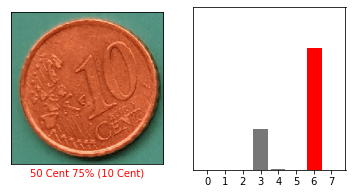

In [65]:
i = 58
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(i, predictions[i], val_labels_shaped, val_images)
plt.subplot(1,2,2)

plot_value_array(i, predictions[i],  val_labels_shaped)
plt.show()

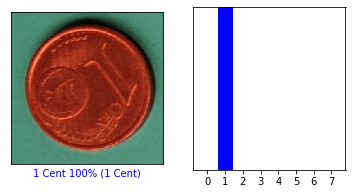

In [66]:
i = 11
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(i, predictions[i], val_labels_shaped, val_images)
plt.subplot(1,2,2)

plot_value_array(i, predictions[i],  val_labels_shaped)
plt.show()

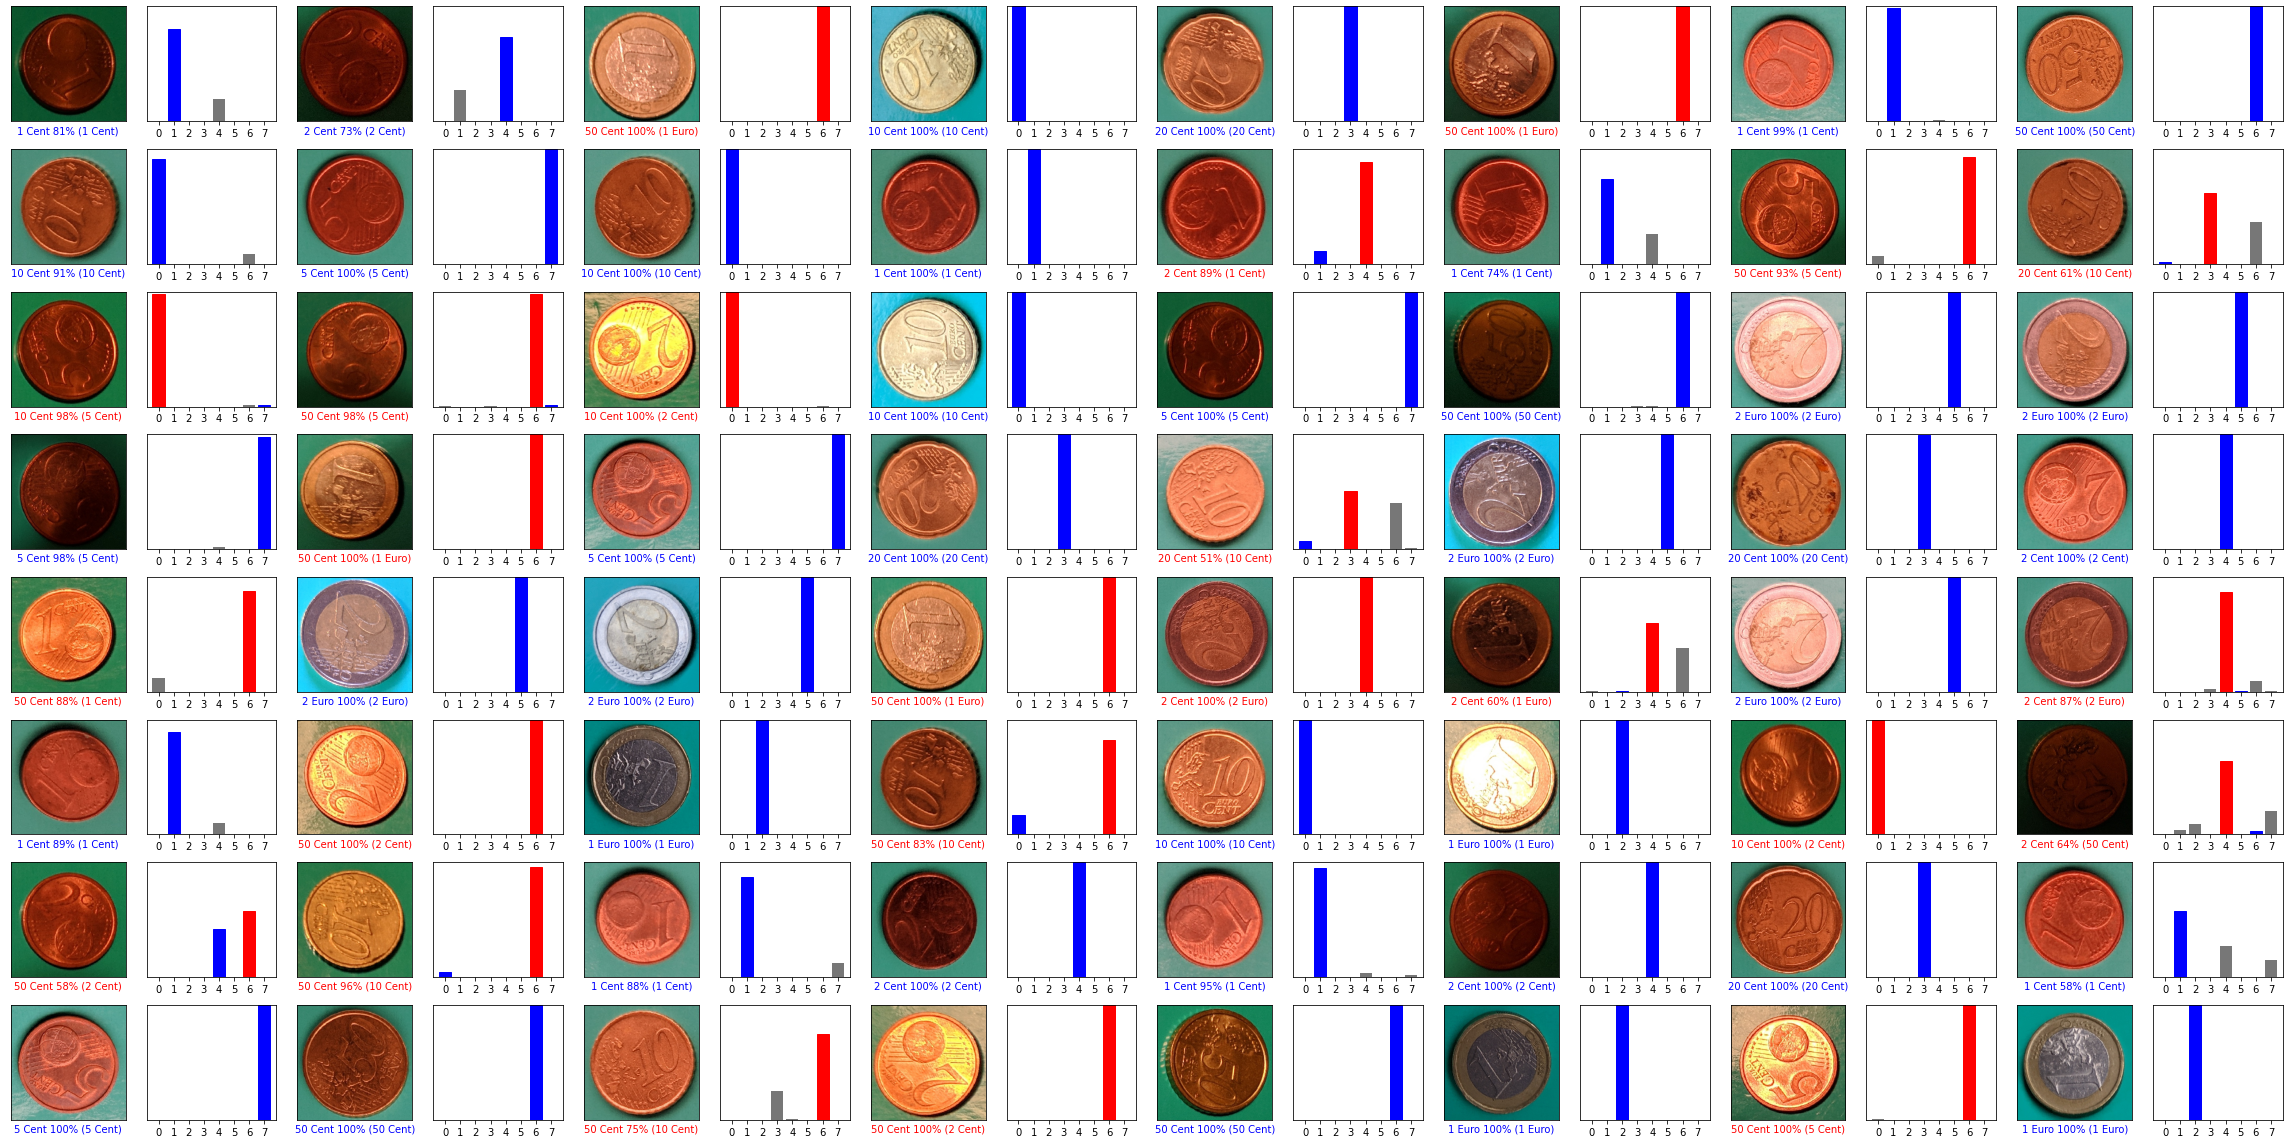

In [67]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], val_labels_shaped, val_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], val_labels_shaped)
plt.tight_layout()
plt.show()